# Convolution on a Music/Audio Signal

## Import Required Libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
from IPython.display import Audio, display, Markdown
import requests
from io import BytesIO

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

## Load and Examine the Audio Signal

In [7]:
# Load the audio file
# sample_rate, audio_data = wavfile.read('W3KM.wav')
audio_url = "https://github.com/mehedi37/DSP_LAB/raw/refs/heads/main/W3KM.wav"
response = requests.get(audio_url)
audio_bytes = BytesIO(response.content)

sample_rate, audio_data = wavfile.read(audio_bytes)


# Convert to mono if stereo
if len(audio_data.shape) > 1:
    audio_data = audio_data[:, 0]

# Normalize audio to range [-1, 1]
if audio_data.dtype == np.int16:
    audio_data = audio_data.astype(np.float32) / 32767.0
elif audio_data.dtype == np.int32:
    audio_data = audio_data.astype(np.float32) / 2147483647.0

# Calculate audio duration
duration = len(audio_data) / sample_rate

# Print audio information
markdown_table = f"""
**Audio Information:**
---
| Property       | Value          |
|----------------|----------------|
| Sample Rate    | {sample_rate} Hz |
| Duration       | {duration:.2f} seconds |
| Channels       | {audio_data.ndim} |
| Sample Count   | {len(audio_data)} |
| Data Type     | {audio_data.dtype} |
"""
display(Markdown(markdown_table))


# Take the first 10 seconds only if audio is longer
if duration > 10:
    audio_data = audio_data[:int(10 * sample_rate)]
    display(Markdown(f"> Truncated to first **10 seconds**: {len(audio_data)} samples"))


**Audio Information:**
---
| Property       | Value          |
|----------------|----------------|
| Sample Rate    | 44100 Hz |
| Duration       | 10.22 seconds |
| Channels       | 1 |
| Sample Count   | 450548 |
| Data Type     | float32 |


> Truncated to first **10 seconds**: 441000 samples

### Visualize the Original Signal

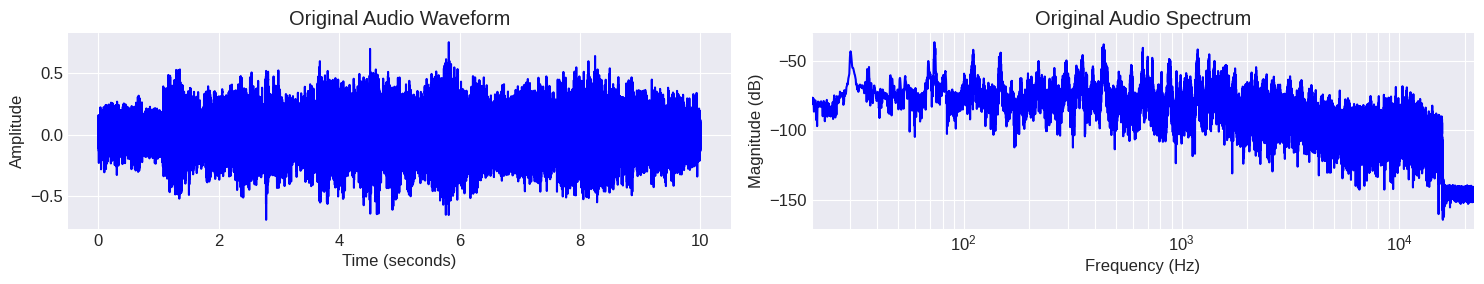

In [8]:
def plot_waveform(signal_data, sr, title="Waveform", alpha=1.0, color='blue'):
    """Plot the waveform of an audio signal"""
    time = np.arange(0, len(signal_data)) / sr
    plt.plot(time, signal_data, alpha=alpha, color=color, label=title)
    plt.grid(True)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title(title)

def plot_spectrum(signal_data, sr, title="Frequency Spectrum", alpha=1.0, color='blue'):
    """Plot the frequency spectrum of an audio signal"""
    # Compute the FFT
    n = len(signal_data)
    yf = np.fft.rfft(signal_data)
    xf = np.fft.rfftfreq(n, 1 / sr)

    # Convert to magnitude in dB
    magnitude = 20 * np.log10(np.abs(yf) / n + 1e-10)

    # Plot the spectrum
    plt.semilogx(xf, magnitude, alpha=alpha, color=color, label=title)
    plt.grid(True, which="both")
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.title(title)
    plt.xlim(20, sr/2)  # Audible frequency range

# Plot the original waveform
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plot_waveform(audio_data, sample_rate, "Original Audio Waveform")

# Plot the original frequency spectrum
plt.subplot(1, 2, 2)
plot_spectrum(audio_data, sample_rate, "Original Audio Spectrum")
plt.tight_layout()
plt.show()

## Design Band-pass Filter for Convolution

In [9]:
def create_bandpass_filter(lowcut, highcut, sample_rate, filter_order=5):
    """Create a band-pass filter using scipy.signal"""
    nyquist = 0.5 * sample_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(filter_order, [low, high], btype='band')
    return b, a

bandpass_b, bandpass_a = create_bandpass_filter(lowcut=500, highcut=3000, sample_rate=sample_rate)  # 500 Hz - 3 kHz

## Apply Filters to Audio Signal

In [10]:
filtered_bandpass = signal.lfilter(bandpass_b, bandpass_a, audio_data)

### Listen to Original & Filtered Audio

In [11]:
# Function to play and display audio player
def play_audio(audio, sr, title):
    print(title)
    display(Audio(audio, rate=sr))

# Play the original audio
play_audio(audio_data, sample_rate, "Original Audio:")

# Play the filtered audio
play_audio(filtered_bandpass, sample_rate, "Band-Pass Filtered Audio:")

Original Audio:


Band-Pass Filtered Audio:


## Compare Waveforms and Frequency Spectra

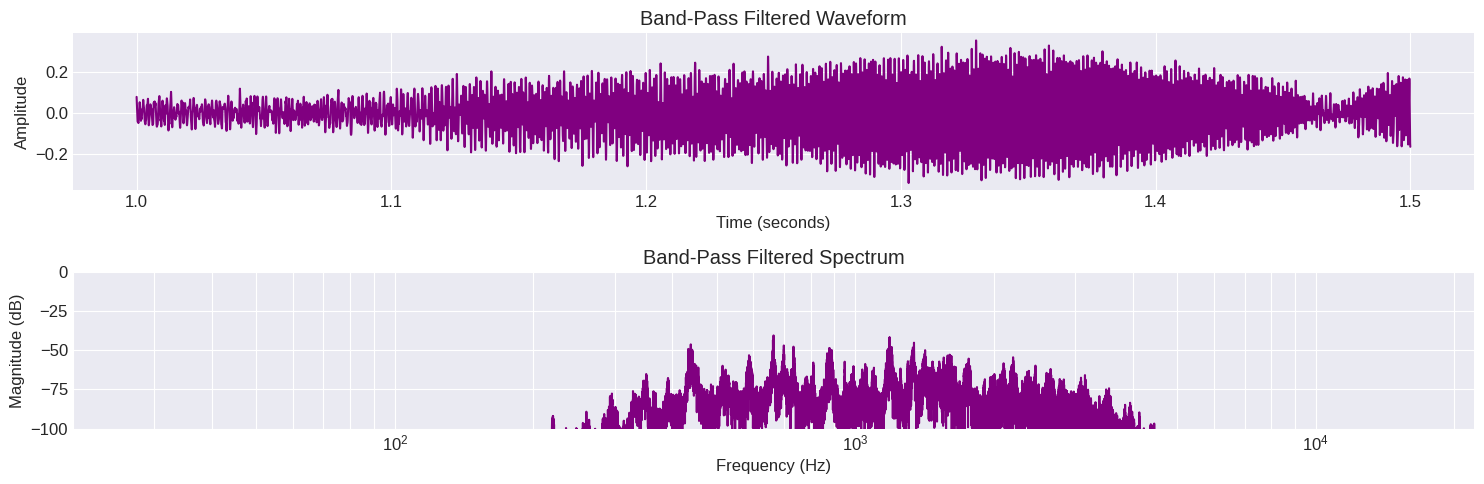

In [14]:
# Time domain waveforms
plt.figure(figsize=(15, 5))

# Plot a smaller section (e.g., 0.5 seconds) for better visibility
section_start = int(1 * sample_rate)  # Start at 1 second
section_duration = int(0.5 * sample_rate)  # Show 0.5 seconds
section_end = section_start + section_duration

time_section = np.arange(section_start, section_end) / sample_rate

# Frequency domain spectrum
plt.subplot(2, 1, 1)
plt.plot(time_section, filtered_bandpass[section_start:section_end], label='Band-Pass', color='purple')
plt.title('Band-Pass Filtered Waveform')
plt.grid(True)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.title('Band-Pass Filtered Spectrum')
plot_spectrum(filtered_bandpass, sample_rate, "Band-Pass Filtered Spectrum", color='purple')
plt.ylim(-100, 0)

plt.tight_layout()
plt.show()

## Overlay Comparison of Original vs. Filtered

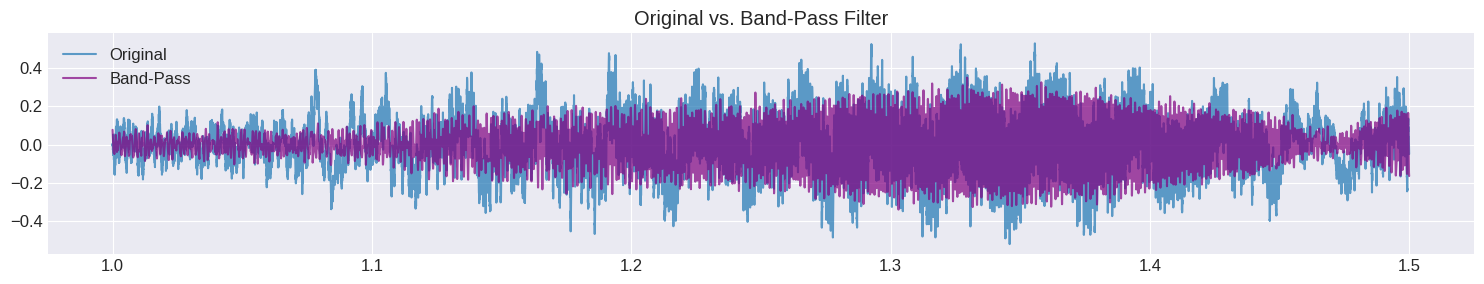

In [13]:
# Compare waveforms (overlay)
plt.figure(figsize=(15, 3))

plt.plot(time_section, audio_data[section_start:section_end], alpha=0.7, label='Original')
plt.plot(time_section, filtered_bandpass[section_start:section_end], alpha=0.7, color='purple', label='Band-Pass')
plt.title('Original vs. Band-Pass Filter')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()